In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from collections import namedtuple

In [125]:
# Weighted random choice
def ChooseW(distr, values=None, rng=None):
    if rng is None: rng = np.random.default_rng(42)

    cumdistr = distr.cumsum()
    w = rng.random() * cumdistr[-1]

    idx = -1
    for i,cum_p in enumerate(cumdistr):
        if w <= cum_p: 
            idx = i
            break
    if values:
        return values[idx]
    return idx


BetaMarkovParams = namedtuple('BetaMarkovParams', 'a, b')
BetaMarkovResult = namedtuple('BetaMarkovResult', 'nvisits, nsteps, history, bin_history')
def MarkovBeta(params: BetaMarkovParams, n_bins=10, stat_offset=2000, n_steps=2000, seed=42, debug=False):
    rng = np.random.default_rng(seed)
    a,b = params
    N = n_bins

    # x is a current state
    # u is a proposed state
    def alpha(x, u):
        return np.nan_to_num(np.minimum(1, 
            (np.float_power(u,a-1) * np.float_power(1-u,b-1))
            /(np.float_power(x,a-1) * np.float_power(1-x,b-1))
        ), nan=1.0)

    def find_bin(x, bins):
        i = 0
        for b in bins:
            if x <= b: return i
            i+=1   

    # modelling
    state = 1/2 # hardcoded initial state
    bins = np.linspace(0,1,n_bins+1)[1:]
    bin_history = []
    history = []
    n_visits = np.zeros(n_bins)
    
    if debug:
        print("bins:", bins)
        print("find bin 0 0.5 1:", find_bin(0,bins), find_bin(0.5,bins), find_bin(1,bins))

        a_arr = alpha(bins.reshape(-1,1), bins)
        print("alphas:")
        print(a_arr)

    # print("first alphas:", alpha(bins[:5].reshape(-1,1), bins[:5]))

    for step in range(n_steps+stat_offset):
        u = rng.random()
        w = rng.random()
        alp = alpha(state, u)
        if w <= alp:
            state = u
        bin = find_bin(state, bins)
        bin_history.append(bin)
        history.append(state)
        if step > stat_offset:
            n_visits[bin] = n_visits[bin] + 1
        
    return BetaMarkovResult(n_visits, n_steps, history, bin_history)


In [129]:
def test_beta(a, b, debug=False, steps=2000, n_bins=10):
    E = np.linspace(0,1,n_bins+1)[1:]
    param = BetaMarkovParams(a, b)
    res = MarkovBeta(param, stat_offset=steps, n_steps=steps, debug=debug, n_bins=n_bins)
    cdf = sp.stats.beta(a,b).cdf
    
    true_distr = cdf(E) - cdf(E-E[0]) # F(b[n+1]) - F(b[n])
    calc_distr = res[0] / res[1]

    plt.title(f"Beta(a={a}, b={b})")
    plt.plot(E, true_distr, '-o', label='true', lw=1)
    plt.plot(E, calc_distr, '-o', label='calc', lw=1)
    # plt.plot(res[2], 'o')
    # plt.plot(np.linspace(0,1,200), sp.stats.beta(a,b).pdf(np.linspace(0,1,200)), '-', label='pdf')
    plt.legend()

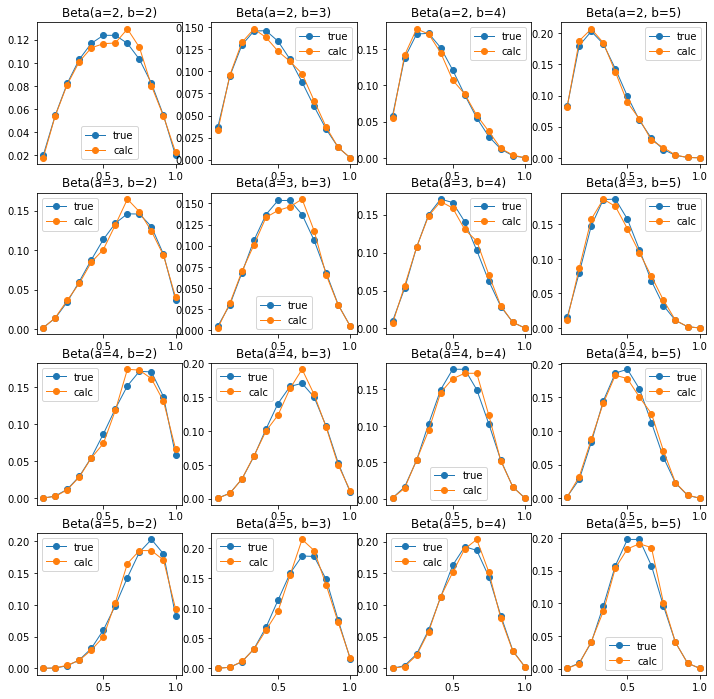

In [130]:
As = [2,3,4,5]
Bs = [2,3,4,5]

plt.gcf().set_size_inches((12,12))

n = 1
for a in As:
    for b in Bs:
        plt.subplot(len(As),len(Bs),n)
        test_beta(a,b,steps=5000, n_bins=12)
        n+=1
